In this notebook, we are primarily interested in analyzing the differences between B cells with VDJs that appear shared between the different tissues, and B cells of the same celltypes that are not shared.

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import scanpy.external as sce
import matplotlib.pyplot as plt
import pathlib
import os
from scipy import stats
import seaborn as sns
import anndata as ad

import celltypist
from celltypist import models

from copy import deepcopy
from glob import glob


In [2]:
adata = sc.read_h5ad('../data/pre_decontX/TBd3_TBd6_B_cells_ambient_filtered.h5ad.gz')

First remove low-confidence cells and clean up the dataframe.

In [3]:
adata=adata[adata.obs.conf_score>0.85]
adata.obs = adata.obs.rename(columns={'celltypist_new':'celltype'})


Make some UMAPs using only the GEX data.

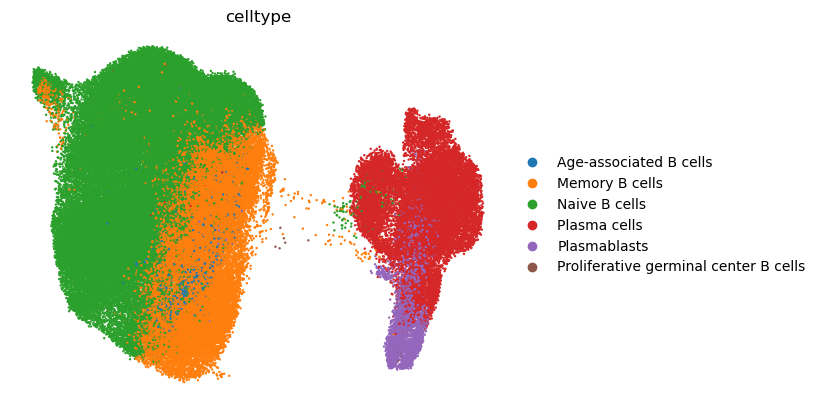

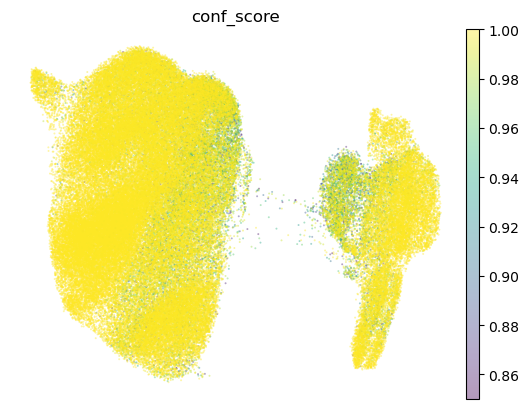

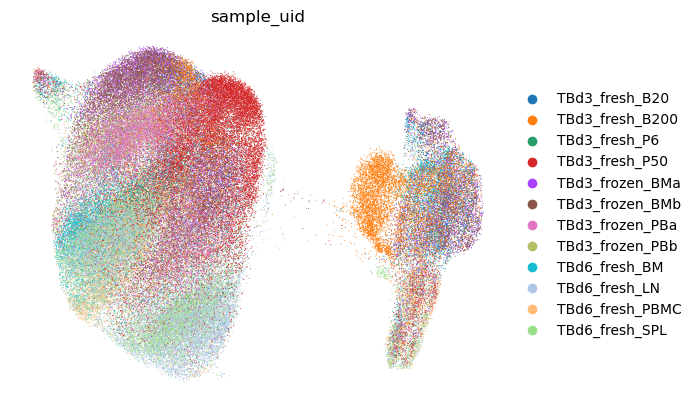

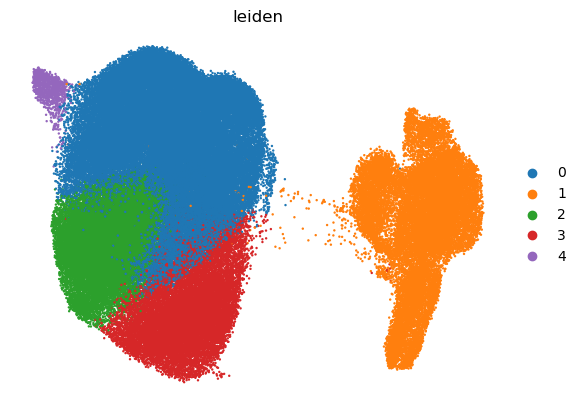

In [4]:
fig=sc.pl.umap(adata, color=['celltype'],size=12, add_outline=False, return_fig=True, frameon=False)
fig.savefig('figures/TBd3_TBd6_umap.pdf', bbox_inches='tight')

fig=sc.pl.umap(adata, color=['conf_score'],size=8, alpha=0.4, add_outline=False, return_fig=True, frameon=False)
fig=sc.pl.umap(adata, color=['sample_uid'],size=2, add_outline=False, return_fig=True, frameon=False)
fig=sc.pl.umap(adata, color=['leiden'],size=12, add_outline=False, return_fig=True, frameon=False)




Find out what distinguishes Leiden cluster 4 from the other ones.

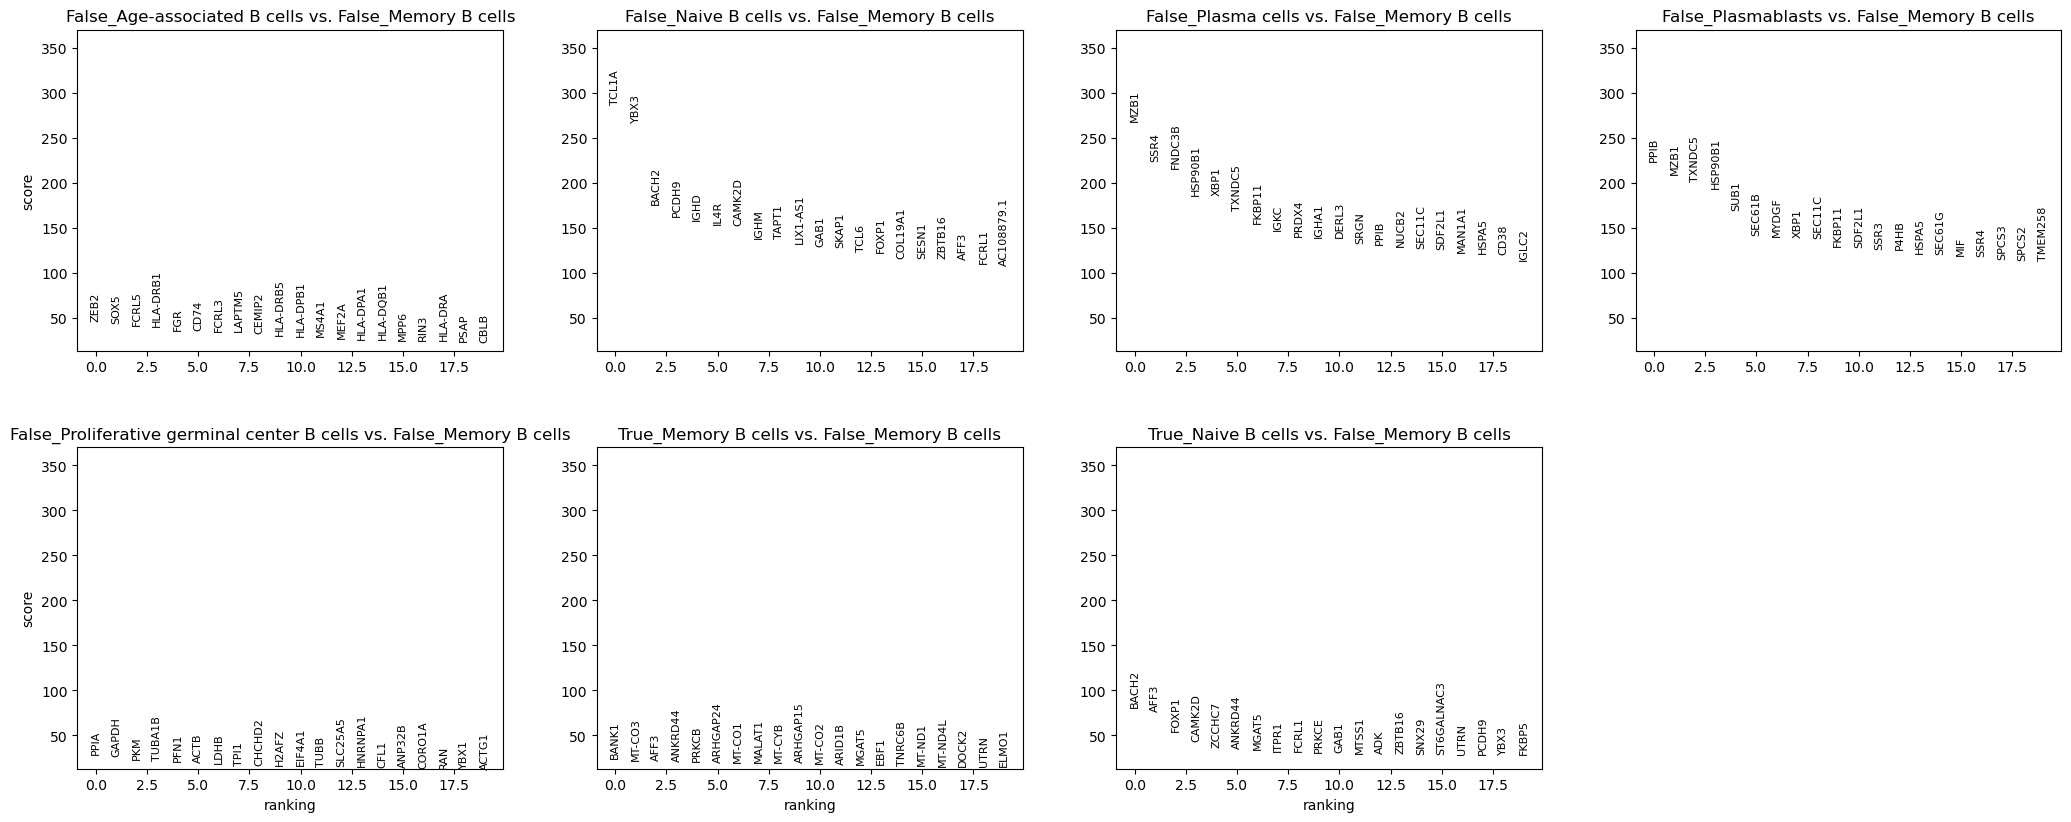

In [7]:
adata.obs['what_are_these'] = ((adata.obs['leiden'] == '4')).astype(str)  
adata.obs['what_are_these'] = adata.obs.what_are_these + "_" + adata.obs['celltype'].astype(str)
adata.obs['what_are_these'] = adata.obs['what_are_these'].astype('category')
sc.tl.rank_genes_groups(adata, 'what_are_these', reference='False_Memory B cells', method='t-test')
sc.pl.rank_genes_groups(adata)

Now bring in the VDJ data:

In [8]:
df=pd.read_table('../../pacbio_bcell_10X/data/combined/TBd3_TBd6_vdj_celltype_with_sharing.tsv.gz', low_memory=False)
df['pacbio'] = df.donor_treatment.isin(['TBd3_fresh','TBd6_fresh'])
df['consensus_c_call'] = df.apply(lambda x: x.c_call if x.pacbio else x.consensus_c_call, axis=1)

In [9]:
new_obs_df = df[['index','vdj_sequence','consensus_c_call','n_umis','cdr3','lineage_id','v_sequence','v_mutations','shared', 'v_pident']]

Some of these droplets correspond to multiplets. Can't interpret their gene-expression patterns, so we will drop them.

In [10]:
new_obs_df = new_obs_df.drop_duplicates(subset='index',keep=False).set_index('index')

Now merge with GEX data:

In [11]:
adata.obs = adata.obs.join(new_obs_df, how='left')
adata.obs.shared = adata.obs.shared.astype('category')
adata.obs.c_call = adata.obs.consensus_c_call.astype('category')
adata.obs['log1p_VH_umis'] = np.log1p(adata.obs.n_umis)/np.log1p(10)
adata.obs['mutation_rate'] = 1. - adata.obs.v_pident.astype(float)/100

Look at some of the VDJ attributes:

... storing 'vdj_sequence' as categorical
... storing 'consensus_c_call' as categorical
... storing 'cdr3' as categorical
... storing 'v_sequence' as categorical
... storing 'v_mutations' as categorical


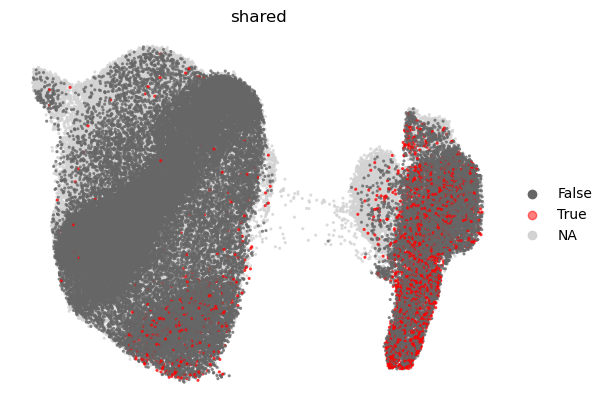

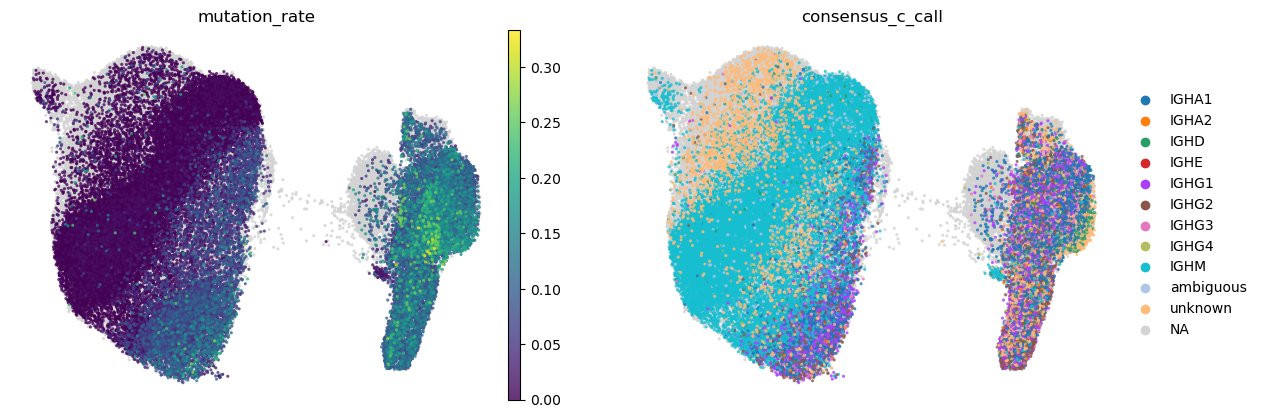

In [12]:
umap_kwargs = dict(s=20,alpha=0.8)#, add_outline=True)
sc.pl.umap(adata, color=['shared'], palette={False:'0.4',True:(1,0,0,0.5),'NA':'0.9'}, **umap_kwargs, frameon=False)#'log1p_VH_umis'],
sc.pl.umap(adata, color=['mutation_rate', 'consensus_c_call'], **umap_kwargs, frameon=False)

### Shared vs not shared gene expression analysis

In [13]:
adata.obs['shared_celltype'] = adata.obs.shared.astype(str) + "_" + adata.obs.celltypist.astype(str)
adata.obs['shared_celltype'] = adata.obs.shared_celltype.map(lambda x: 'na' if x.startswith('na') else x)
adata.obs.shared_celltype = adata.obs.shared_celltype.astype('category')


First, collect the marker genes for each cell type by doing a bunch of pairwise comparisons.

In [19]:
marker_genes = {}
rank_genes_groups = {}
for celltype in ['Memory B cells', 'Naive B cells', 'Plasmablasts', 'Plasma cells']:
    sc.tl.rank_genes_groups(adata, 'shared_celltype', method='t-test', reference='False_'+celltype, rank_abs=True)
    marker_genes[celltype] = adata.uns['rank_genes_groups']['names']['True_'+celltype]
    rank_genes_groups[celltype] = adata.uns['rank_genes_groups']


We will now populate a dataframe containing top 25 of the differentially expressed genes, which we will later use to build a classifier.

We will also plot the distribution of the expression of the top 10 differentially expressed genes, as well as their sum.

['True_Memory B cells', 'False_Memory B cells']
['True_Naive B cells', 'False_Naive B cells']
['True_Plasmablasts', 'False_Plasmablasts']
['True_Plasma cells', 'False_Plasma cells']


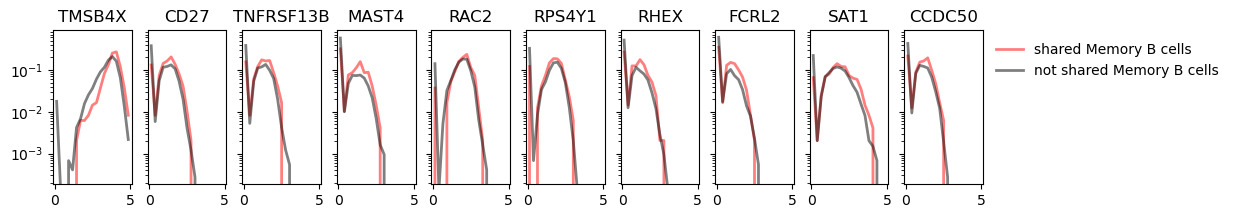

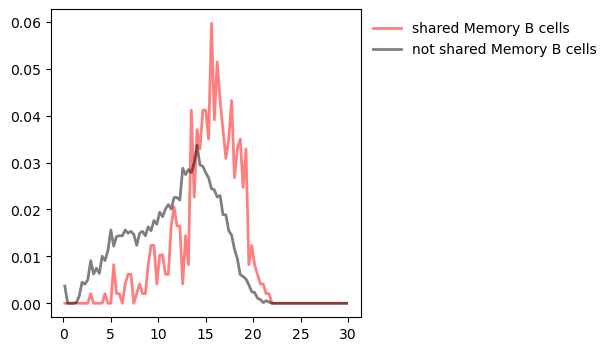

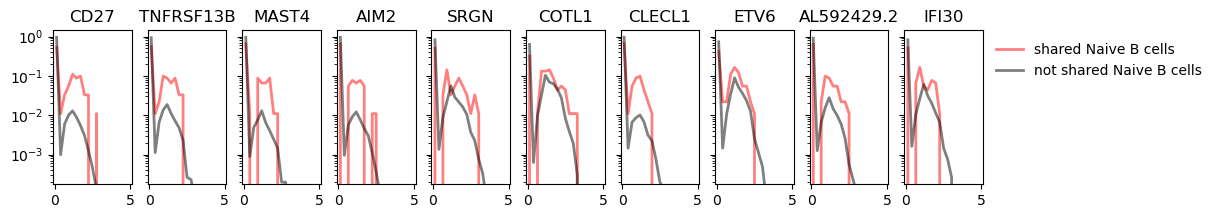

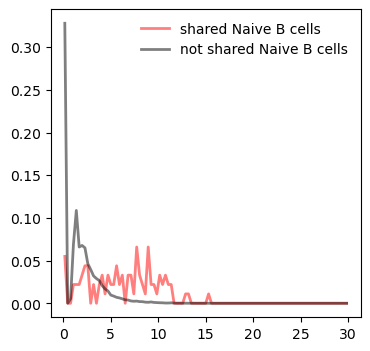

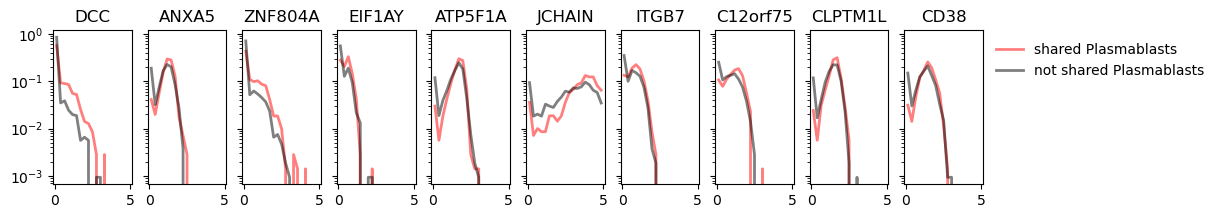

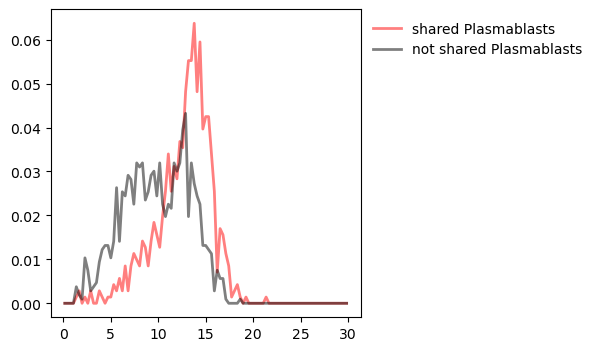

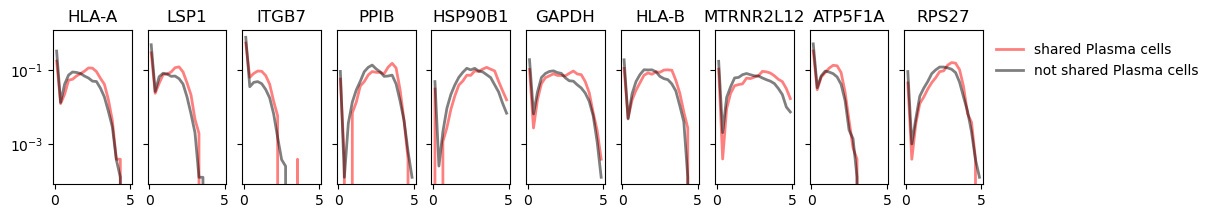

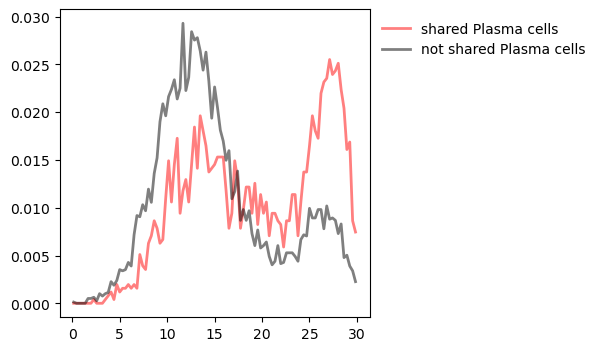

In [20]:
bins = np.linspace(0,5,20)
sum_obs_bins = np.linspace(0,30,100)

bin_centers = (bins[1:] + bins[:-1])/2.
sum_obs_bin_centers = (sum_obs_bins[1:] + sum_obs_bins[:-1])/2.

N_GENES_FOR_CLASSIFIER=25
NGENES = 10
not_shared_color='k'
shared_color='r'
color_kwargs = dict(lw=2, alpha=0.5)
all_obs_dfs = {}
for celltype in marker_genes.keys():
    obs_dfs = []
    groups=['True_'+celltype, 'False_'+celltype]
    print(groups)
    fig, ax = plt.subplots(1,NGENES, figsize=(12,2), sharey=True)
    fig_totals, ax_totals = plt.subplots(figsize=(4,4))
    sum_obs=None
    for i, gene in enumerate(marker_genes[celltype][:N_GENES_FOR_CLASSIFIER]):
        obs_df = sc.get.obs_df(adata, gene)
        if sum_obs is None:
            sum_obs = pd.DataFrame({gene:obs_df})
        else:
            sum_obs = sum_obs.join(pd.DataFrame({gene:obs_df}))
        if i < NGENES:
            ax[i].set_title(gene)

            shared = obs_df[adata.obs.shared_celltype==groups[0]]
            not_shared = obs_df[adata.obs.shared_celltype==groups[1]]


            counts_shared, bins = np.histogram(shared, bins=bins)
            counts_not_shared, bins = np.histogram(not_shared, bins=bins)
            ax[i].plot(bin_centers, (counts_shared)/np.sum(counts_shared), label='shared '+celltype,
                      color=shared_color, **color_kwargs)
            ax[i].plot(bin_centers, (counts_not_shared)/np.sum(counts_not_shared), 
                       color = not_shared_color, label='not shared '+ celltype, **color_kwargs)
            ax[i].set_yscale('log')
            
    ax[-1].legend(loc='best', frameon=False, bbox_to_anchor=(1,1))
    fig.savefig('figures/{}_shared_vs_not_shared_genes.pdf'.format(celltype), bbox_inches='tight')
    i = i+1
    
    obs_dfs.append(sum_obs)
    shared = sum_obs[adata.obs.shared_celltype==groups[0]].iloc[:,:NGENES].sum(axis=1)
    not_shared = sum_obs[adata.obs.shared_celltype==groups[1]].iloc[:,:NGENES].sum(axis=1)


    counts_shared, _ = np.histogram(shared, bins=sum_obs_bins)
    counts_not_shared, _ = np.histogram(not_shared, bins=sum_obs_bins)
    ax_totals.plot(sum_obs_bin_centers, (counts_shared)/np.sum(counts_shared), label='shared '+celltype,
              color=shared_color, **color_kwargs)
    ax_totals.plot(sum_obs_bin_centers, (counts_not_shared)/np.sum(counts_not_shared), 
               color = not_shared_color, label='not shared '+ celltype, **color_kwargs)
#     ax_totals.set_yscale('log')
    ax_totals.legend(loc='best', frameon=False, bbox_to_anchor=(1,1))
    all_obs_dfs.update({celltype: pd.concat(obs_dfs)})

Now build a simple classifier:

In [21]:
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn import metrics


Memory B cells 7069 785 0.9719745222929936
Naive B cells 27321 3036 0.9957180500658761
Plasmablasts 1593 177 0.8135593220338984
Plasma cells 9526 1058 0.8459357277882797


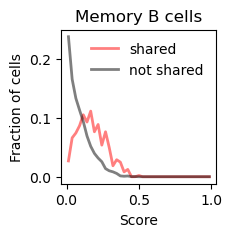

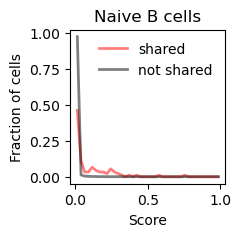

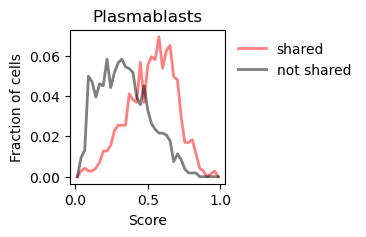

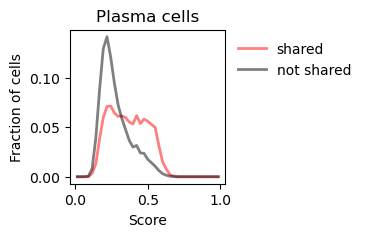

In [22]:
for celltype, obs in all_obs_dfs.items():

    y = adata.obs['shared']
    obs = obs[y.notna() & (adata.obs.celltypist==celltype)]
    y = y[y.notna()& (adata.obs.celltypist==celltype)].astype(bool)
        
    ntrain = round(obs.shape[0]*0.9)
    ntest = obs.shape[0] - ntrain
    
    training = obs.head(ntrain)
    test = obs.tail(ntest)
    training_y = y.head(ntrain)
    test_y = y.tail(ntest)

    clf = LogisticRegression(random_state=0).fit(training, training_y)
    
    score = clf.score(test, test_y)
    print(celltype, ntrain, ntest, score)
    y_test = clf.predict(test)
    cm = metrics.confusion_matrix(y_test, test_y)
   
    log_probs = clf.predict_log_proba(obs)
    probs = np.exp(log_probs)/(1 + np.exp(log_probs))
    probs = probs.T[1]/(probs.T[0]+probs.T[1])
    
    fig_lr, ax_lr = plt.subplots(figsize=(2,2))
    ax_lr.set_xlabel('Score')
    ax_lr.set_ylabel('Fraction of cells')
    bins = np.linspace(0,1,40)
    bin_centers = (bins[1:]+bins[:-1])/2
    counts_shared, bins = np.histogram(probs[y], bins=bins)
    counts_not_shared, bins = np.histogram(probs[~y], bins=bins)
    ax_lr.set_title(celltype)
    ax_lr.plot(bin_centers, (counts_shared)/np.sum(counts_shared), label='shared',
              color=shared_color, **color_kwargs)
    ax_lr.plot(bin_centers, (counts_not_shared)/np.sum(counts_not_shared), 
               color = not_shared_color, label='not shared' , **color_kwargs)
    #     ax_totals.set_yscale('log')
    ax_lr.legend(loc='best', frameon=False, bbox_to_anchor=(1,1))    
    fig_lr.savefig('figures/{}_shared_vs_not_shared_score.pdf'.format(celltype), bbox_inches='tight')



Quickly and sloppily investigate whether LLPCs appear to be shared more often than other PCs.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


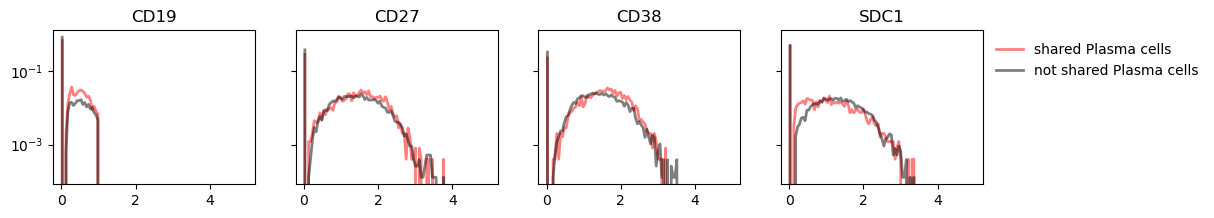

In [24]:
celltype='Plasma cells'
NGENES=4
bins= np.linspace(0,5,100)
bin_centers = (bins[1:]+bins[:-1])/2.
fig, ax = plt.subplots(1,NGENES, figsize=(12,2), sharey=True)
CD19 = sc.get.obs_df(adata, 'CD19')#[adata.obs.celltype=='Plasma cells']
CD27 = sc.get.obs_df(adata, 'CD27')#[adata.obs.celltype=='Plasma cells']
CD38 = sc.get.obs_df(adata, 'CD38')#[adata.obs.celltype=='Plasma cells']
SDC1 = sc.get.obs_df(adata, 'SDC1')#[adata.obs.celltype=='Plasma cells']
CD19_low = CD19 < 1

for i, gene in enumerate(['CD19','CD27','CD38','SDC1']):
    ax[i].set_title(gene)
    obs_df = sc.get.obs_df(adata, gene)
    shared = obs_df[(adata.obs.shared_celltype=='True_'+celltype) & (CD19_low)]
    not_shared = obs_df[(adata.obs.shared_celltype=='False_'+celltype) & (CD19_low)]

    counts_shared, bins = np.histogram(shared, bins=bins)
    counts_not_shared, bins = np.histogram(not_shared, bins=bins)
    ax[i].plot(bin_centers, (counts_shared)/np.sum(counts_shared), label='shared '+celltype,
              color=shared_color, **color_kwargs)
    ax[i].plot(bin_centers, (counts_not_shared)/np.sum(counts_not_shared), 
               color = not_shared_color, label='not shared '+ celltype, **color_kwargs)
    ax[i].set_yscale('log')

    ax[-1].legend(loc='best', frameon=False, bbox_to_anchor=(1,1))
    fig.savefig('figures/{}_shared_vs_not_shared_genes.pdf'.format(celltype), bbox_inches='tight')


Define an LLPC GEX signature and count them up

In [ ]:
LLPC = (CD19 < 0.2) & (CD27>1) & (CD38>2) & (SDC1>1) & (adata.obs.celltypist=='Plasma cells')
adata.obs['LLPC_sig'] = LLPC
LLPC_shared = adata.obs.groupby(['LLPC_sig','shared']).size()
LLPC_shared = LLPC_shared.reset_index().pivot(index='LLPC_sig',columns='shared', values=0)

In [ ]:
LLPC_shared
LLPC_shared=LLPC_shared.rename(columns={True:'shared',False:'not shared'})
LLPC_shared = LLPC_shared/LLPC_shared.sum(axis=0)